3.1
40 45
The slack node(s) is/are  [38]


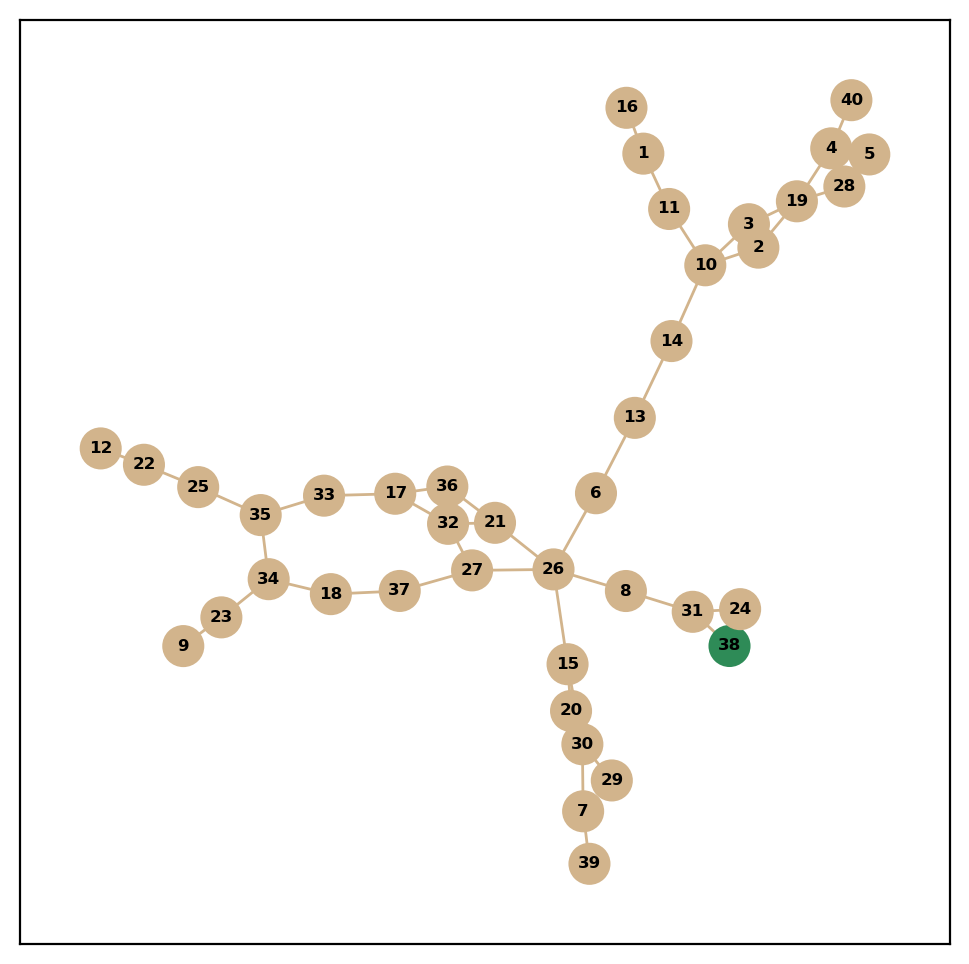

{'pos': (48.6811671875, 8.46216553204)}


In [2]:
import networkx as nx
print(nx.__version__)
import matplotlib.pyplot as plt


import json
with open("GasLib-40-split/network.json", "r") as read_file:
    network_data = json.load(read_file)

slack_nodes = []


G = nx.Graph()
G.clear()
for pipe_id in network_data['pipes']:
    G.add_edge(network_data['pipes'][pipe_id]['fr_node'], network_data['pipes'][pipe_id]['to_node'])
for comp_id in network_data['compressors']:
    G.add_edge(network_data['compressors'][comp_id]['fr_node'], network_data['compressors'][comp_id]['to_node'])

print(G.number_of_nodes(), G.number_of_edges())

for node_id in network_data['nodes']:
    if network_data['nodes'][node_id]['slack_bool'] == 1:
        slack_nodes.append(int(node_id))
    G.nodes[int(node_id)]["pos"] = (network_data['nodes'][node_id]['x_coord'], network_data['nodes'][node_id]['y_coord'])
print("The slack node(s) is/are ", [int(s) for s in slack_nodes])
slack_id = slack_nodes[0] #38, if multiple slacks, pick one of them 

pos = nx.get_node_attributes(G, "pos")
pos = nx.spring_layout(G, pos=pos, k=0.25, seed=10)

plt.figure(figsize=(6, 6), dpi=200)
color_list = ['seagreen' if node_name == slack_id else 'tan' for node_name in list(G.nodes)]
nx.draw_networkx(G, pos=pos, with_labels=True, node_size= 200, font_size=6, font_weight='bold', node_color=color_list, edge_color="tan")
plt.show()

print(G.nodes[1])

In [26]:

# from networkx.algorithms.community.kernighan_lin import kernighan_lin_bisection
# out = kernighan_lin_bisection(G)
# G1 = G.copy()
# for (v1, v2) in G.edges():
#     if (v1 in out[0]) and (v2 in out[1]):
#         print(v1, v2)
#         G1.remove_edge(v1, v2) 
#     if (v2 in out[0]) and (v1 in out[1]):
#         print(v1, v2)
#         G.remove_edge(v2, v1) 
# print(len(out[0]), len(out[1]))

# pos1 = nx.get_node_attributes(G1, "pos")
# pos1 = nx.spring_layout(G1, pos=pos, k=0.25, seed=10)

# plt.figure(figsize=(6, 6), dpi=200)
# color_list = ['seagreen' if node_name == slack_id else 'tan' for node_name in list(G1.nodes)]
# nx.draw_networkx(G1, pos=pos1, with_labels=True, node_size= 200, font_size=6, font_weight='bold', node_color=color_list, edge_color="tan")
# plt.show()

from networkx.algorithms.components import is_biconnected
print(is_biconnected(G))
#remember term block-cut tree

P = list(nx.articulation_points(G))
print(list(P))
def my_degree(n):
    return G.degree[n]

print(sorted(P, reverse=True,key=my_degree))

from networkx.algorithms.bridges import bridges
Q = list(bridges(G))
print(Q)

# note that [33, 18] is a cut set of vertices. anyway to compute this ?




False
[4, 19, 31, 8, 26, 23, 34, 22, 25, 35, 7, 30, 15, 6, 13, 14, 1, 11, 10]
[26, 19, 30, 10, 4, 31, 34, 35, 15, 8, 23, 22, 25, 7, 6, 13, 14, 1, 11]
[(10, 14), (10, 11), (38, 31), (31, 24), (31, 8), (15, 26), (1, 16), (1, 11), (30, 7), (30, 29), (26, 8), (26, 6), (7, 39), (34, 23), (23, 9), (6, 13), (13, 14), (35, 25), (4, 40), (25, 22), (22, 12)]


In [257]:
max_degree_index = 1
for i in range(1, 41):
    if G.degree[i] > max_degree_index:
        max_degree_index = G.degree[i]
    else:
        continue
print(max_degree_index)

max_degree_nodes = []
for i in range(1, 41):
    if G.degree[i] == max_degree_index:
        max_degree_nodes.append(i)
    else:
        continue
print(max_degree_nodes)


5
[26]


In [27]:
# interface_node_list = [26]
# interface_node_list = [26, 14]
# interface_node_list = [14, 15, 35]
# interface_node_list = [26, 14, 19]
# interface_node_list = [21, 27]
# interface_node_list = [33, 18]
# interface_node_list = [2, 3]
interface_node_list = [21, 27, 32]

nbr_sets = []
for i in interface_node_list:
    nbr_sets.append( list(G.neighbors(i)) )
print(nbr_sets)

[[32, 36, 26], [32, 26, 37], [21, 17, 27]]


In [28]:
for i in range(len(interface_node_list)):
    nbrs = nbr_sets[i]
    node = interface_node_list[i]
    print(node, nbrs)
    for i in nbrs:
        if (node, i) in G.edges():
            G.remove_edge(node, i) 
            
len_subnetworks_array = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
print(len_subnetworks_array)

num_isolated_nodes = 0
for num in len_subnetworks_array:
    if num == 1:
        num_isolated_nodes += 1

if num_isolated_nodes != len(interface_node_list):
    print("Number of isolated node subnetworks is {}, expect/want {}".format(num_isolated_nodes, len(interface_node_list)))
    

21 [32, 36, 26]
27 [32, 26, 37]
32 [21, 17, 27]
[25, 12, 1, 1, 1]


In [29]:
S = [G.subgraph(c).copy() for c in sorted(nx.connected_components(G), key=len, reverse=False)]
# remove first len(interface_node_list) subnetworks since they will be singleton interface nodes
S = S[len(interface_node_list):]
for SG in S:
    print(SG.nodes())
    

# # now knowing slack node is 38, put subnetwork with slack node as first one

for ni, SG in enumerate(S):
    if slack_id not in SG.nodes():
        print("Slack node {} NOT in subnetwork {}+1 ".format(slack_id, ni))
        continue
    else:
        print("Found slack node {} in subnetwork {}+1 ".format(slack_id, ni))
        
    if ni == 0:
        break 
        
    SG_temp = S[0]
    S[0] = SG
    S[ni] = SG_temp
    break
    
S_fig = []
for SG in S:
    print(SG.nodes())
    S_fig.append(SG.copy())

    


partition_dict = {}
for ni, SG in enumerate(S):
    for i in range(len(interface_node_list)):
        intf_node = interface_node_list[i]
        nbrs = nbr_sets[i]
        for node in nbrs:
            if node in SG.nodes():
                SG.add_edge(intf_node, node) 
    partition_dict[ni+1] = list(SG.nodes())
    print(partition_dict[ni+1])
    
S[0].nodes[38]

[33, 34, 35, 36, 37, 9, 12, 17, 18, 22, 23, 25]
[10, 2, 28, 5, 38, 31, 20, 15, 1, 16, 30, 26, 8, 7, 6, 13, 14, 19, 3, 11, 4, 24, 29, 40, 39]
Slack node 38 NOT in subnetwork 0+1 
Found slack node 38 in subnetwork 1+1 
[10, 2, 28, 5, 38, 31, 20, 15, 1, 16, 30, 26, 8, 7, 6, 13, 14, 19, 3, 11, 4, 24, 29, 40, 39]
[33, 34, 35, 36, 37, 9, 12, 17, 18, 22, 23, 25]
[10, 2, 28, 5, 38, 31, 20, 15, 1, 16, 30, 26, 8, 7, 6, 13, 14, 19, 3, 11, 4, 24, 29, 40, 39, 21, 27, 32]
[33, 34, 35, 36, 37, 9, 12, 17, 18, 22, 23, 25, 21, 27, 32]


{'pos': (48.9636070987, 6.83756607565)}

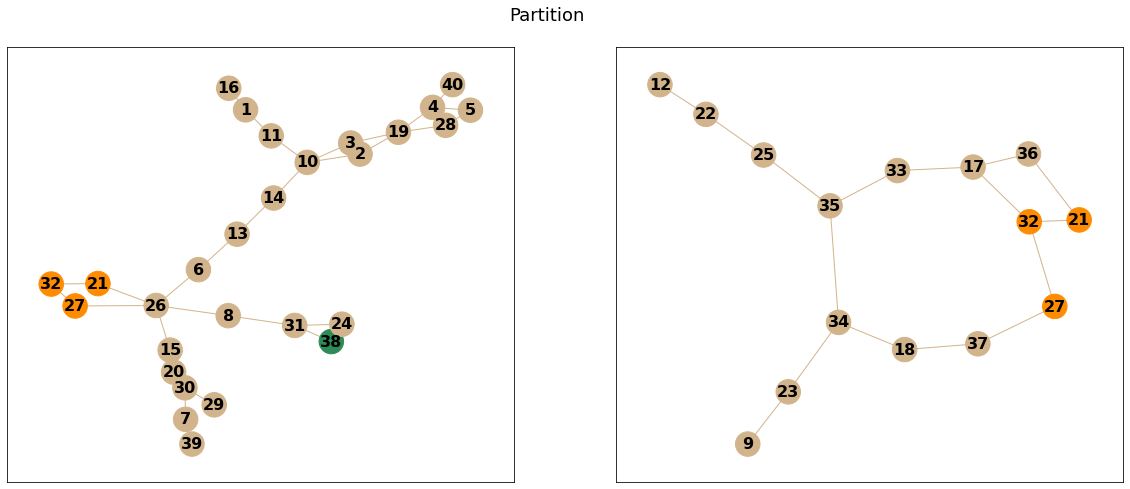

In [369]:
m = len(S)
plt.figure(figsize=(20, 8))
plt.subplots_adjust(hspace=0.25)
plt.suptitle("Partition", fontsize=18, y=0.95)
for ni, SG in enumerate(S):
    pos_dict = {}
    for i in SG.nodes():
        pos_dict[i]= pos[i]
    ax = plt.subplot(1, m, ni+1)
    color_list = ['darkorange' if node_name in interface_node_list else 'seagreen' if node_name == slack_id else 'tan' for node_name in list(SG.nodes)]
    nx.draw_networkx(SG, pos=pos_dict, with_labels=True, node_size= 600, font_size=16, font_weight='bold', node_color=color_list, edge_color="tan")



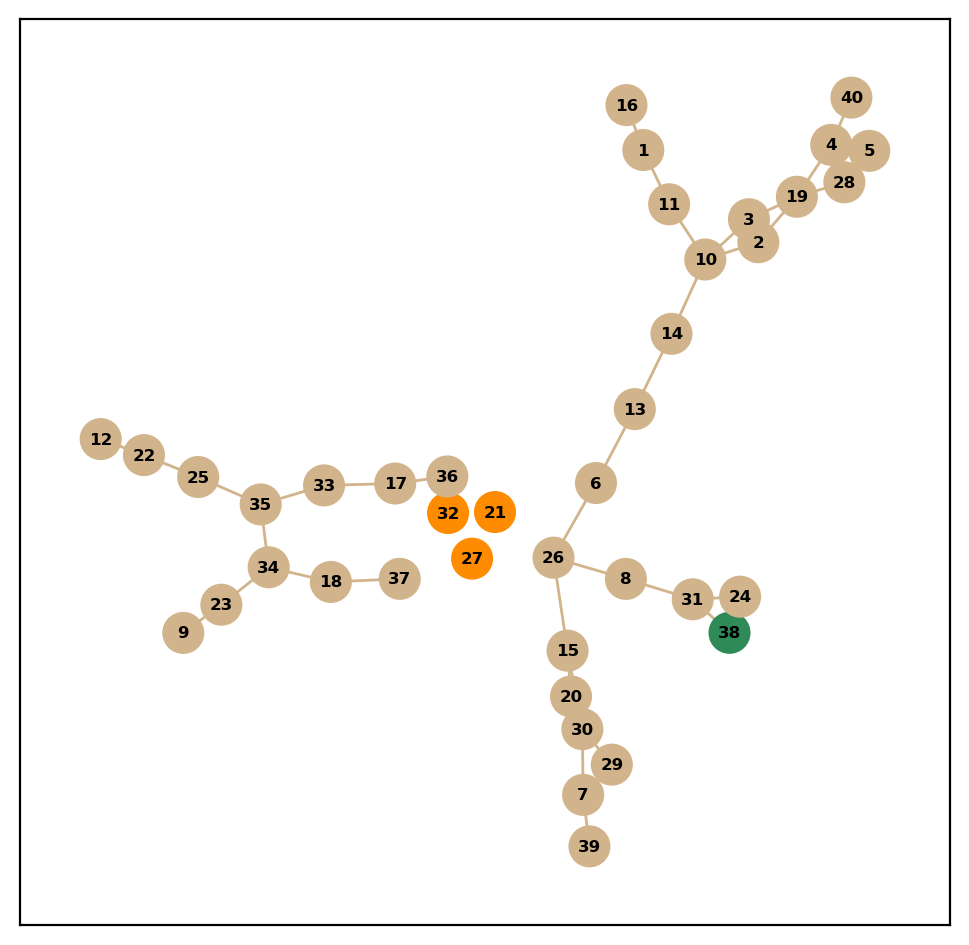

In [370]:


plt.figure(figsize=(6, 6), dpi=200)
color_list = ['darkorange' if node_name in interface_node_list else 'seagreen' if node_name == slack_id else 'tan' for node_name in list(G.nodes)]
nx.draw_networkx(G, pos=pos, with_labels=True, node_size= 200, font_size=6, font_weight='bold', node_color=color_list, edge_color="tan")
plt.show()

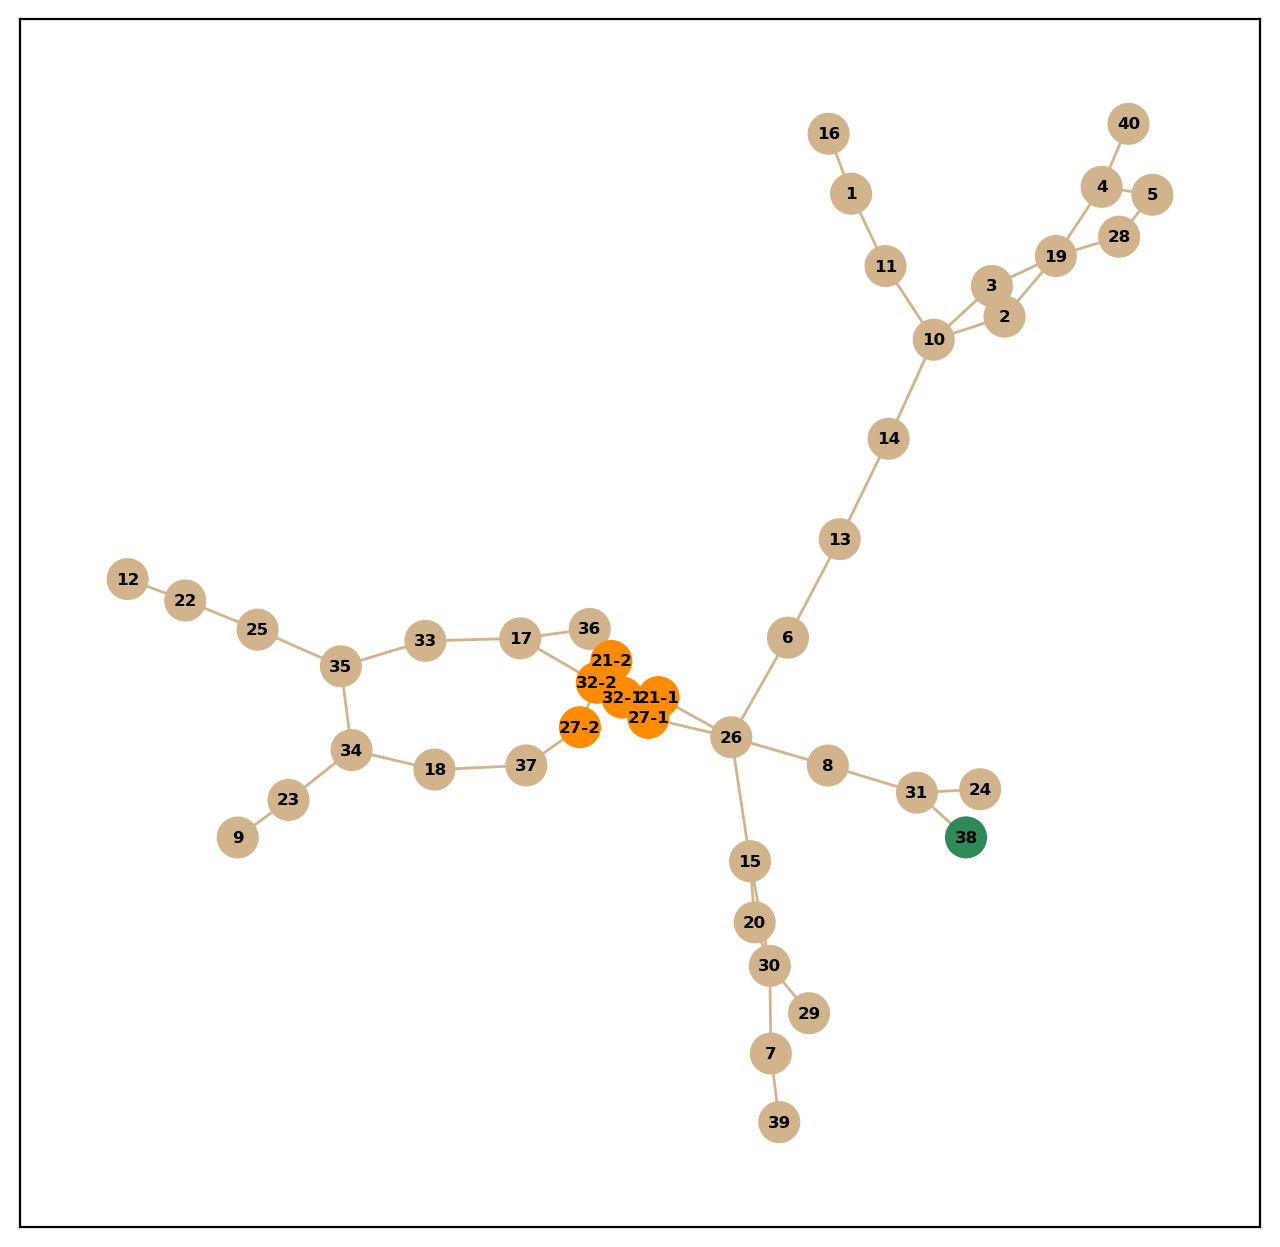

In [372]:


# for ni, SG in enumerate(S_fig):
#     for i in range(len(interface_node_list)):
#         intf_node = interface_node_list[i]
#         nbrs = nbr_sets[i]
#         for node in nbrs:
#             if node in SG.nodes():
#                 node_str = "{}-{}".format(intf_node, ni+1)
#                 SG.add_edge(node_str, node)
#                 SG.nodes[node_str]["pos"] = G.nodes[intf_node]["pos"]
#                 x_coord = []
#                 y_coord = []
#                 x_coord.append(pos[intf_node][0])
#                 y_coord.append(pos[intf_node][1])
#                 for node in list(SG.neighbors(node_str)):
#                     x_coord.append(pos[node][0])
#                     y_coord.append(pos[node][1])
#                 pos[node_str] = (sum(x_coord)/len(x_coord), sum(y_coord)/len(y_coord))

# For partition at [21, 27, 32] previous block does not work 
for ni, SG in enumerate(S_fig):
    for i in range(len(interface_node_list)):
        intf_node = interface_node_list[i]
        node_str1 = "{}-{}".format(intf_node, ni+1)
        nbrs = nbr_sets[i]
        for node in nbrs:
            if (intf_node, node) in S[ni].edges():
                if node in interface_node_list:
                    node_str2 = "{}-{}".format(node, ni+1)
                    SG.add_edge(node_str1, node_str2)
#                     SG.nodes[node_str1]["pos"] = G.nodes[intf_node]["pos"]
#                     SG.nodes[node_str2]["pos"] = G.nodes[node]["pos"]
#                     pos[node_str1] = pos[intf_node]
#                     pos[node_str2] = pos[node]
                else:
                    SG.add_edge(node_str1, node)
#                     SG.nodes[node_str1]["pos"] = G.nodes[intf_node]["pos"]
                x_coord = []
                y_coord = []
                x_coord.append(pos[intf_node][0])
                y_coord.append(pos[intf_node][1])
                for node in list(S[ni].neighbors(intf_node)):
                    x_coord.append(pos[node][0])
                    y_coord.append(pos[node][1])
                pos[node_str1] = (sum(x_coord)/len(x_coord), sum(y_coord)/len(y_coord))

                
                    
                
G_fig = nx.Graph()

for ni, SG in enumerate(S_fig):
    G_fig = nx.union(G_fig, SG)

plt.figure(figsize=(8, 8), dpi=200)
color_list = ['darkorange' if isinstance(node_name, str)   else 'seagreen' if node_name == slack_id else 'tan' for node_name in list(G_fig.nodes)]
nx.draw_networkx(G_fig, pos=pos, with_labels=True, node_size= 200, font_size=6, font_weight='bold', node_color=color_list, edge_color="tan")
plt.show()



add the edges netween interface nodes manually !


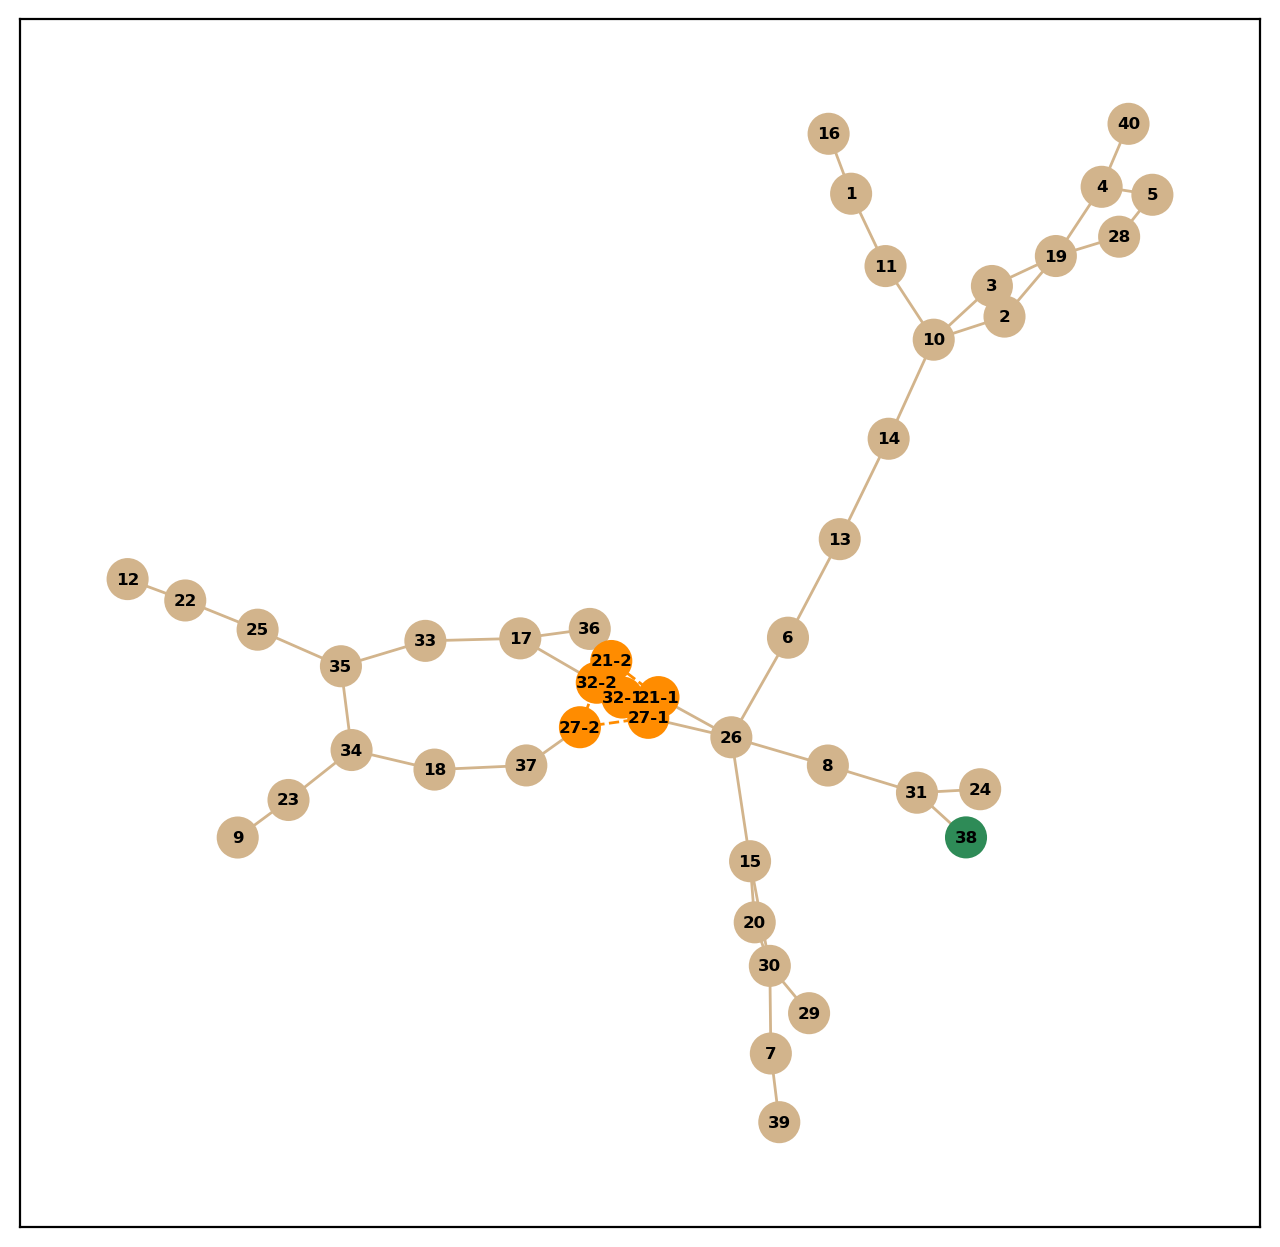

In [373]:
print("add the edges netween interface nodes manually !")
# G_fig.add_edges_from([("26-1", "26-2"), ("26-1", "26-3"), ("26-1", "26-4")])
# G_fig.add_edges_from([("26-1", "26-5"), ("26-1", "26-3"), ("26-1", "26-2"), ("14-2", "14-4")])
# G_fig.add_edges_from([("35-1", "35-4"), ("15-1", "15-2"), ("14-1", "14-3")])
# G_fig.add_edges_from([("26-1", "26-5"), ("26-1", "26-3"), ("26-1", "26-6"), ("14-3", "14-4"), ("19-2", "19-4")])
# G_fig.add_edges_from([("21-1", "21-2"), ("27-1", "27-2")])
# G_fig.add_edges_from([("33-1", "33-2"), ("18-1", "18-2")])
# G_fig.add_edges_from([("2-1", "2-2"), ("3-1", "3-2")])
G_fig.add_edges_from([("21-1", "21-2"), ("27-1", "27-2"), ("32-1", "32-2")])






plt.figure(figsize=(8, 8), dpi=200)
color_list = ['darkorange' if isinstance(node_name, str)   else 'seagreen' if node_name == slack_id else 'tan' for node_name in list(G_fig.nodes)]
nx.draw_networkx_nodes(G_fig, pos=pos,  node_size= 200, node_color=color_list)
edge_list1 =[]
edge_list2 = []
for edge in list(G_fig.edges):
    if isinstance(edge[0], str) and isinstance(edge[1], str):
        edge_list1.append(edge)
    else:
        edge_list2.append(edge)
        
nx.draw_networkx_edges(G_fig, pos=pos, edgelist = edge_list1, style="--", edge_color= "darkorange")
nx.draw_networkx_edges(G_fig, pos=pos, edgelist = edge_list2, edge_color="tan")
nx.draw_networkx_labels(G_fig, pos=pos,  font_size=6, font_weight='bold')
plt.show()


In [247]:
save_data = False
 
if save_data:
    print("Writing to json...")
    with open("GasLib-40-split/partition8.json", "w") as outfile:
        json.dump(partition_dict, outfile)
    print("Completed writing to json...")
else:
    print("Flag is set to false, not writing")

Flag is set to false, not writing


[1, 21, 27, 32, 2]


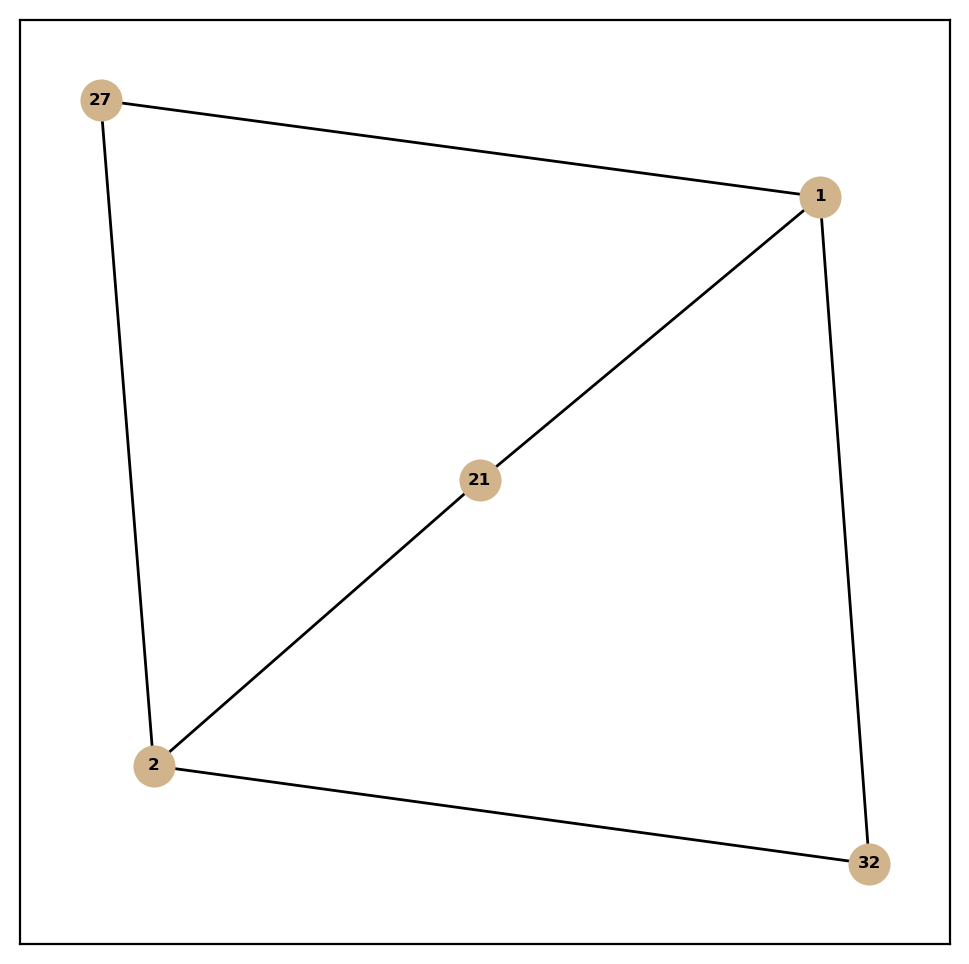

In [45]:
G = nx.Graph()
G.clear()
for i in range(1, len(partition_dict)+1):
    for j in interface_node_list:
        if j in set(partition_dict[i]):
            G.add_edge(i, j)
            if i not in G.nodes():
                    G.add_node(i)
            if j not in G.nodes():
                    G.add_node(j)
                
print(G.nodes())
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6), dpi=200)
# color_list = ['seagreen' if node_name in interface_node_list else 'tan']
nx.draw_networkx(G, with_labels=True, node_size= 200, font_size=6, font_weight='bold', node_color='tan', edge_color="black")
plt.show()

In [37]:
len(partition_dict)

2